In [2]:
import torch
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
from scipy.signal import welch, butter, filtfilt, sosfiltfilt

# Choose GPU if available, otherwise fallback to CPU
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(DEVICE)

cpu


In [3]:
# Set variances for initial states
# variance2 = 10
# variance1 = 1 / variance2 # Inverse variance
variance2 = 10 ** 0.8
variance1 = 10 ** -0.5 # Inverse variance

N = 100  # Number of modes
total_sample_num = int(1e6)  # Total number of samples

# Helper function to draw 2D scatter plots of sampled Gaussian distributions
def draw_scatter(samples1, samples2, label1, label2):
    plt.figure(figsize=(6, 6))
    plt.scatter(samples1, samples2, s=10, alpha=0.6, edgecolors='k', linewidths=0.3)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.xlabel(label1)
    plt.ylabel(label2)
    plt.title('Samples from Gaussian State')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal')  # Make x and y axis scales equal
    plt.show()

# Function to check if a matrix is positive semidefinite
def check_psd(matrix, tol=1e-8):
    if not np.allclose(matrix, matrix.T, atol=tol):
        raise ValueError("Matrix is not symmetric.")  # PSD requires symmetry
    eigenvalues = np.linalg.eigvalsh(matrix)  # Eigenvalues for symmetric matrix
    min_eig = np.min(eigenvalues)
    is_psd = min_eig >= -tol  # Allow small numerical errors
    violation = 0 if is_psd else abs(min_eig)
    return is_psd, violation

# Define phase shift transformation matrix for a specific mode
def phase_shift90(mode, phi=np.pi/2):
    S = torch.eye(2*N, device=DEVICE)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    idx = 2 * mode
    S[idx, idx] = cos_phi
    S[idx, idx+1] = sin_phi
    S[idx+1, idx] = -sin_phi
    S[idx+1, idx+1] = cos_phi
    return S

# Define beamsplitter transformation between two modes
def beam_splitter(mode1, mode2, theta=np.pi/4):
    S = torch.eye(2 * N, device=DEVICE)
    c = np.cos(theta)
    s = np.sin(theta)
    i = 2 * mode1
    j = 2 * mode2
    indices = [i, i+1, j, j+1]
    # BS_block = torch.tensor([
    #     [c, 0,  s, 0],
    #     [0, c,  0, s],
    #     [-s, 0, c, 0],
    #     [0, -s, 0, c]
    # ], dtype=S.dtype, device=DEVICE)
    BS_block = torch.tensor([
        [c, 0, -s, 0],
        [0, c,  0,-s],
        [s, 0,  c, 0],
        [0, s,  0, c]
    ], dtype=S.dtype, device=DEVICE)
    S[np.ix_(indices, indices)] = BS_block
    return S

def beam_splitter_timeevolution(INmode1, INmode2, theta=np.pi/4):
    c = np.cos(theta)
    s = np.sin(theta)
    OUTmode1 = INmode1 * c - INmode2 * s
    OUTmode2 = INmode1 * c + INmode2 * s
    return OUTmode1, OUTmode2

def split_into_temporal_modes(samples, N, modes_space_num=0):
    sample_num_per_temporal_mode = samples.shape[0] // N - modes_space_num
    temporal_modes_samples = torch.zeros((sample_num_per_temporal_mode, N, 2)).to(DEVICE)
    for i in range(N):
        temporal_modes_samples[:, i, :] = samples[(sample_num_per_temporal_mode+modes_space_num)*i:(sample_num_per_temporal_mode+modes_space_num)*i+sample_num_per_temporal_mode, :]
    return temporal_modes_samples

def combine_temporal_modes(samples, modes_space_num=0):
    sample_num_per_temporal_mode = samples.shape[0]
    combined_samples = torch.zeros((sample_num_per_temporal_mode*(samples.shape[1]+modes_space_num), 2)).to(DEVICE)
    for i in range(samples.shape[1]):
        combined_samples[(sample_num_per_temporal_mode+modes_space_num)*i:(sample_num_per_temporal_mode+modes_space_num)*i+sample_num_per_temporal_mode, :] = samples[:, i, :]
    return combined_samples

def delay_line(samples, delay_num):
    delay_num = int(delay_num)
    shifted = torch.zeros_like(samples)
    if delay_num > 0:
        shifted[delay_num:] = samples[:-delay_num]
    elif delay_num < 0:
        shifted[:delay_num] = samples[-delay_num:]
    else:
        shifted = samples
    return shifted

In [4]:
# Filter
def butter_lowpass_filter(data, cutoff, fs, order=5, output='sos'):
    if output == 'ba':
        b, a = butter(order, cutoff, btype='low', fs=fs, output='ba')
        y = filtfilt(b, a, data)
    elif output == 'sos':
        sos = butter(order, cutoff, btype='low', fs=fs, output='sos')
        y = sosfiltfilt(sos, data)
    else:
        raise ValueError("output must be 'ba' or 'sos'")
    return y
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, output='sos'):
    if output == 'ba':
        b, a = butter(order, [lowcut, highcut], btype='band', fs=fs, output='ba')
        y = filtfilt(b, a, data)
    elif output == 'sos':
        sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
        y = sosfiltfilt(sos, data)
    else:
        raise ValueError("output must be 'ba' or 'sos'")
    return y

In [5]:
# Normalize data to unit variance
def normalize_data(data, bound_data, verbose=False):
    std_bound = np.std(bound_data)
    normalized_data = data / std_bound
    if verbose:
        print(f"===== Normalized data info =====")
        print(f"Data mean: {np.mean(data)}, Data std: {np.std(data)}")
        print(f"Normalized data mean: {np.mean(normalized_data)}, Normalized data std: {np.std(normalized_data)}")
        print(f"Variance comparison with bound data(dB): {10*np.log10(np.var(data) / np.var(bound_data))}")
    return normalized_data

```
mode0(...,4,2,0) -- ###### -- mode1(...,2,0) ----------- mode2(...,4,2,0) -- ###### -- mode3(...,6,4,2)
                   # BS #                                                    # BS #                    
mode0(...,5,3,1) -- ###### -- mode1(...,3,1) -- DELAY -- mode2(...,3,1,X) -- ###### -- mode3(...,5,3,1)
```

In [112]:
# Import time domain samples
header_rows = 0
# sampling_rate = 100e6  # Sampling rate in Hz
# raw_exp_data0 = pd.read_csv('data/20250401/时域压缩/RigolDS0.csv', skiprows=header_rows, nrows=2500000, usecols=[0]) # 带通x
# raw_exp_data1 = pd.read_csv('data/20250401/时域压缩/RigolDS1.csv', skiprows=header_rows, nrows=2500000, usecols=[0]) # 带通p
# raw_exp_data2 = pd.read_csv('data/20250401/时域压缩/RigolDS2.csv', skiprows=header_rows, nrows=2500000, usecols=[0]) # 带通vac
# raw_exp_data3 = pd.read_csv('data/20250401/时域压缩/RigolDS3.csv', skiprows=header_rows, nrows=2500000, usecols=[0]) # 直出vac
# raw_exp_data4 = pd.read_csv('data/20250401/时域压缩/RigolDS4.csv', skiprows=header_rows, nrows=2500000, usecols=[0]) # 直出p
# raw_exp_data5 = pd.read_csv('data/20250401/时域压缩/RigolDS5.csv', skiprows=header_rows, nrows=2500000, usecols=[0]) # 直出x

raw_exp_data0 = pd.read_csv('data/20250401/时域压缩/RigolDS0.csv', skiprows=header_rows, usecols=[0]) # 带通x
raw_exp_data1 = pd.read_csv('data/20250401/时域压缩/RigolDS1.csv', skiprows=header_rows, usecols=[0]) # 带通p
raw_exp_data2 = pd.read_csv('data/20250401/时域压缩/RigolDS2.csv', skiprows=header_rows, usecols=[0]) # 带通vac
raw_exp_data3 = pd.read_csv('data/20250401/时域压缩/RigolDS3.csv', skiprows=header_rows, usecols=[0]) # 直出vac
raw_exp_data4 = pd.read_csv('data/20250401/时域压缩/RigolDS4.csv', skiprows=header_rows, usecols=[0]) # 直出p
raw_exp_data5 = pd.read_csv('data/20250401/时域压缩/RigolDS5.csv', skiprows=header_rows, usecols=[0]) # 直出x

raw_exp_data0 = raw_exp_data0.values.flatten()
raw_exp_data1 = raw_exp_data1.values.flatten()
raw_exp_data2 = raw_exp_data2.values.flatten()
raw_exp_data3 = raw_exp_data3.values.flatten()
raw_exp_data4 = raw_exp_data4.values.flatten()
raw_exp_data5 = raw_exp_data5.values.flatten()

# # Filter the data
# filter_lower_bound = 1e6
# filter_upper_bound = 8e6
# filter_sampling_rate = 100e6
# raw_exp_data3 = butter_bandpass_filter(raw_exp_data3, filter_lower_bound, filter_upper_bound, filter_sampling_rate, order=5)
# raw_exp_data4 = butter_bandpass_filter(raw_exp_data4, filter_lower_bound, filter_upper_bound, filter_sampling_rate, order=5)
# raw_exp_data5 = butter_bandpass_filter(raw_exp_data5, filter_lower_bound, filter_upper_bound, filter_sampling_rate, order=5)

# # Normalize the data
raw_exp_data0 = normalize_data(raw_exp_data0, raw_exp_data2, verbose=True)
raw_exp_data1 = normalize_data(raw_exp_data1, raw_exp_data2, verbose=True)
raw_exp_data4 = normalize_data(raw_exp_data4, raw_exp_data3, verbose=True)
raw_exp_data5 = normalize_data(raw_exp_data5, raw_exp_data3, verbose=True)
raw_exp_data2 = normalize_data(raw_exp_data2, raw_exp_data2, verbose=True)
raw_exp_data3 = normalize_data(raw_exp_data3, raw_exp_data3, verbose=True)

# Convert to tensor and move to device
raw_exp_data0 = torch.tensor(raw_exp_data0, dtype=torch.float32).to(DEVICE)
raw_exp_data1 = torch.tensor(raw_exp_data1, dtype=torch.float32).to(DEVICE)
raw_exp_data2 = torch.tensor(raw_exp_data2, dtype=torch.float32).to(DEVICE)
raw_exp_data3 = torch.tensor(raw_exp_data3.copy(), dtype=torch.float32).to(DEVICE)
raw_exp_data4 = torch.tensor(raw_exp_data4.copy(), dtype=torch.float32).to(DEVICE)
raw_exp_data5 = torch.tensor(raw_exp_data5.copy(), dtype=torch.float32).to(DEVICE)

# Constructe initial state
# initial_raw_samples = torch.stack((raw_exp_data0, raw_exp_data1), dim=1) # 带通x和p
initial_raw_samples = torch.stack((raw_exp_data5, raw_exp_data4), dim=1) # 直出x和p
initial0_samples = initial_raw_samples[:total_sample_num, :].to(DEVICE)  # 取前total_sample_num个样本
initial1_samples = initial_raw_samples[-total_sample_num:, :].to(DEVICE)  # 取后total_sample_num个样本
initial1_samples = initial1_samples[:, [1, 0]]

===== Normalized data info =====
Data mean: 0.00023973738478409997, Data std: 0.0007722895891759547
Normalized data mean: 0.17043272781989335, Normalized data std: 0.5490316892740728
Variance comparison with bound data(dB): -5.208051760190038
===== Normalized data info =====
Data mean: 0.00031413627637400014, Data std: 0.004455737832539532
Normalized data mean: 0.2233239614998736, Normalized data std: 3.167647607126051
Variance comparison with bound data(dB): 10.014737228594775
===== Normalized data info =====
Data mean: -0.006948970417588004, Data std: 0.26527826698304885
Normalized data mean: -1.1070449168734138, Normalized data std: 42.261650197455864
Variance comparison with bound data(dB): 32.518929020278065
===== Normalized data info =====
Data mean: 0.0004145303969440001, Data std: 0.01745054347567796
Normalized data mean: 0.06603910237765269, Normalized data std: 2.780057230137599
Variance comparison with bound data(dB): 8.881074727549494
===== Normalized data info =====
Data m

In [126]:
# Generate random initial sigle mode Gaussian state samples
initial0_mean = torch.zeros(2).to(DEVICE)
initial0_covariance = torch.diag(torch.tensor([variance1,variance2])).to(DEVICE)
initial1_mean = torch.zeros(2).to(DEVICE)
initial1_covariance = torch.diag(torch.tensor([variance2,variance1])).to(DEVICE)
initial0_samples = torch.distributions.multivariate_normal.MultivariateNormal(initial0_mean, initial0_covariance).sample((total_sample_num,)).to(DEVICE)
initial1_samples = torch.distributions.multivariate_normal.MultivariateNormal(initial1_mean, initial1_covariance).sample((total_sample_num,)).to(DEVICE)

真空态：

In [140]:
# initial_raw_samples_vac = torch.stack((raw_exp_data2[:4000000], raw_exp_data2[-4000000:]), dim=1) # 带通vac
# initial_raw_samples_vac = torch.stack((raw_exp_data3[:4000000], raw_exp_data3[-4000000:]), dim=1) # 直出vac
initial_raw_samples_vac = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2)).sample((10000000,)).to(DEVICE) # 模拟vac
initial0_samples_vac = initial_raw_samples_vac[:total_sample_num, :].to(DEVICE)  # 取前total_sample_num个样本
initial1_samples_vac = initial_raw_samples_vac[-total_sample_num:, :].to(DEVICE)  # 取后total_sample_num个样本
initial1_samples_vac = initial1_samples_vac[:, [1, 0]]

initial0_samples_mode0_vac = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial1_samples_mode0_vac = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial0_samples_mode0_vac = initial0_samples_vac
initial1_samples_mode0_vac = initial1_samples_vac

# Split into temporal modes
sample_num_per_mode = total_sample_num // N 
mode0_samples_vac = torch.zeros((sample_num_per_mode, N*2, 2)).to(DEVICE)
for i in tqdm(range(0, N)):
    mode0_samples_vac[:, 2*i,  :] = split_into_temporal_modes(initial0_samples_vac, N, modes_space_num=0)[:, i, :]
    mode0_samples_vac[:, 2*i+1,:] = split_into_temporal_modes(initial1_samples_vac, N, modes_space_num=0)[:, i, :]

# First beam splitter
# for i in tqdm(range(0, N)):
#     mode1_samples[:, 2*i, :] , mode1_samples[:, 2*i+1, :] = beam_splitter_timeevolution(mode0_samples[:, 2*i, :], mode0_samples[:, 2*i+1, :], theta=np.pi/4)
initial0_samples_mode1_vac = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial1_samples_mode1_vac = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial0_samples_mode1_vac, initial1_samples_mode1_vac = beam_splitter_timeevolution(initial0_samples_vac, initial1_samples_vac, theta=np.pi/4)
# mode1_samples = torch.zeros((sample_num_per_mode, N*2, 2)).to(DEVICE)
# for i in tqdm(range(0, N)):
#     mode1_samples[:, 2*i,  :] = split_into_temporal_modes(initial0_samples_mode1, N, modes_space_num=0)[:, i, :]
#     mode1_samples[:, 2*i+1,:] = split_into_temporal_modes(initial1_samples_mode1, N, modes_space_num=0)[:, i, :]

# Delay
delay_num = sample_num_per_mode * 1.000
initial0_samples_mode2_vac = initial0_samples_mode1_vac
initial1_samples_mode2_vac = delay_line(initial1_samples_mode1_vac, delay_num=delay_num)
# mode2_samples = torch.zeros((sample_num_per_mode, N*2, 2)).to(DEVICE)
# for i in tqdm(range(0, N-1)):
#     mode2_samples[:, 2*i, :] = mode1_samples[:, 2*i+2, :]
#     mode2_samples[:, 2*i+1, :] = mode1_samples[:, 2*i+1, :]

# Second beam splitter
# for i in tqdm(range(0, N)):
#     mode3_samples[:, 2*i, :] , mode3_samples[:, 2*i+1, :] = beam_splitter_timeevolution(mode2_samples[:, 2*i, :], mode2_samples[:, 2*i+1, :], theta=np.pi/4)
initial0_samples_mode3_vac = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial1_samples_mode3_vac = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial0_samples_mode3_vac, initial1_samples_mode3_vac = beam_splitter_timeevolution(initial0_samples_mode2_vac, initial1_samples_mode2_vac, theta=np.pi/4)
mode3_samples_vac = torch.zeros((sample_num_per_mode, N*2, 2)).to(DEVICE)
for i in tqdm(range(0, N)):
    mode3_samples_vac[:, 2*i,  :] = split_into_temporal_modes(initial0_samples_mode3_vac, N, modes_space_num=0)[:, i, :]
    mode3_samples_vac[:, 2*i+1,:] = split_into_temporal_modes(initial1_samples_mode3_vac, N, modes_space_num=0)[:, i, :]

# Apply bandpass filter to each column of initial0_samples_mode3 and initial1_samples_mode3
filter_lower_bound = 1e6
filter_upper_bound = 8e6
filter_sampling_rate = 100e6
initial0_samples_mode4_vac = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial1_samples_mode4_vac = torch.zeros((total_sample_num, 2)).to(DEVICE)
for col in range(initial0_samples_mode3_vac.shape[1]):
    initial0_samples_mode4_vac[:, col] = torch.tensor(
        butter_bandpass_filter(
            initial0_samples_mode3_vac[:, col].cpu().numpy(),
            filter_lower_bound,
            filter_upper_bound,
            filter_sampling_rate,
            order=5
        ).copy(),
        dtype=torch.float32
    ).to(DEVICE)
for col in range(initial1_samples_mode3_vac.shape[1]):
    initial1_samples_mode4_vac[:, col] = torch.tensor(
        butter_bandpass_filter(
            initial1_samples_mode3_vac[:, col].cpu().numpy(),
            filter_lower_bound,
            filter_upper_bound,
            filter_sampling_rate,
            order=5
        ).copy(),
        dtype=torch.float32
    ).to(DEVICE)

mode4_samples_vac = torch.zeros((sample_num_per_mode, N*2, 2)).to(DEVICE)
for i in tqdm(range(0, N)):
    mode4_samples_vac[:, 2*i,  :] = split_into_temporal_modes(initial0_samples_mode4_vac, N, modes_space_num=0)[:, i, :]
    mode4_samples_vac[:, 2*i+1,:] = split_into_temporal_modes(initial1_samples_mode4_vac, N, modes_space_num=0)[:, i, :]


100%|██████████| 100/100 [00:03<00:00, 25.70it/s]


压缩态：

In [128]:
initial0_samples_mode0 = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial1_samples_mode0 = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial0_samples_mode0 = initial0_samples
initial1_samples_mode0 = initial1_samples

# Split into temporal modes
sample_num_per_mode = total_sample_num // N 
mode0_samples = torch.zeros((sample_num_per_mode, N*2, 2)).to(DEVICE)
for i in tqdm(range(0, N)):
    mode0_samples[:, 2*i,  :] = split_into_temporal_modes(initial0_samples, N, modes_space_num=0)[:, i, :]
    mode0_samples[:, 2*i+1,:] = split_into_temporal_modes(initial1_samples, N, modes_space_num=0)[:, i, :]

# First beam splitter
# for i in tqdm(range(0, N)):
#     mode1_samples[:, 2*i, :] , mode1_samples[:, 2*i+1, :] = beam_splitter_timeevolution(mode0_samples[:, 2*i, :], mode0_samples[:, 2*i+1, :], theta=np.pi/4)
initial0_samples_mode1 = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial1_samples_mode1 = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial0_samples_mode1, initial1_samples_mode1 = beam_splitter_timeevolution(initial0_samples, initial1_samples, theta=np.pi/4)
# mode1_samples = torch.zeros((sample_num_per_mode, N*2, 2)).to(DEVICE)
# for i in tqdm(range(0, N)):
#     mode1_samples[:, 2*i,  :] = split_into_temporal_modes(initial0_samples_mode1, N, modes_space_num=0)[:, i, :]
#     mode1_samples[:, 2*i+1,:] = split_into_temporal_modes(initial1_samples_mode1, N, modes_space_num=0)[:, i, :]

# Delay
delay_num = sample_num_per_mode * 1.000
initial0_samples_mode2 = initial0_samples_mode1
initial1_samples_mode2 = delay_line(initial1_samples_mode1, delay_num=delay_num)
# mode2_samples = torch.zeros((sample_num_per_mode, N*2, 2)).to(DEVICE)
# for i in tqdm(range(0, N-1)):
#     mode2_samples[:, 2*i, :] = mode1_samples[:, 2*i+2, :]
#     mode2_samples[:, 2*i+1, :] = mode1_samples[:, 2*i+1, :]

# Second beam splitter
# for i in tqdm(range(0, N)):
#     mode3_samples[:, 2*i, :] , mode3_samples[:, 2*i+1, :] = beam_splitter_timeevolution(mode2_samples[:, 2*i, :], mode2_samples[:, 2*i+1, :], theta=np.pi/4)
initial0_samples_mode3 = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial1_samples_mode3 = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial0_samples_mode3, initial1_samples_mode3 = beam_splitter_timeevolution(initial0_samples_mode2, initial1_samples_mode2, theta=np.pi/4)
mode3_samples = torch.zeros((sample_num_per_mode, N*2, 2)).to(DEVICE)
for i in tqdm(range(0, N)):
    mode3_samples[:, 2*i,  :] = split_into_temporal_modes(initial0_samples_mode3, N, modes_space_num=0)[:, i, :]
    mode3_samples[:, 2*i+1,:] = split_into_temporal_modes(initial1_samples_mode3, N, modes_space_num=0)[:, i, :]

# Apply bandpass filter to each column of initial0_samples_mode3 and initial1_samples_mode3
filter_lower_bound = 1e6
filter_upper_bound = 8e6
filter_sampling_rate = 100e6
initial0_samples_mode4 = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial1_samples_mode4 = torch.zeros((total_sample_num, 2)).to(DEVICE)
for col in range(initial0_samples_mode3.shape[1]):
    initial0_samples_mode4[:, col] = torch.tensor(
        butter_bandpass_filter(
            initial0_samples_mode3[:, col].cpu().numpy(),
            filter_lower_bound,
            filter_upper_bound,
            filter_sampling_rate,
            order=5
        ).copy(),
        dtype=torch.float32
    ).to(DEVICE)
for col in range(initial1_samples_mode3.shape[1]):
    initial1_samples_mode4[:, col] = torch.tensor(
        butter_bandpass_filter(
            initial1_samples_mode3[:, col].cpu().numpy(),
            filter_lower_bound,
            filter_upper_bound,
            filter_sampling_rate,
            order=5
        ).copy(),
        dtype=torch.float32
    ).to(DEVICE)

mode4_samples = torch.zeros((sample_num_per_mode, N*2, 2)).to(DEVICE)
for i in tqdm(range(0, N)):
    mode4_samples[:, 2*i,  :] = split_into_temporal_modes(initial0_samples_mode4, N, modes_space_num=0)[:, i, :]
    mode4_samples[:, 2*i+1,:] = split_into_temporal_modes(initial1_samples_mode4, N, modes_space_num=0)[:, i, :]


100%|██████████| 100/100 [00:03<00:00, 26.00it/s]


Sampling rate: 100000.0 kHz


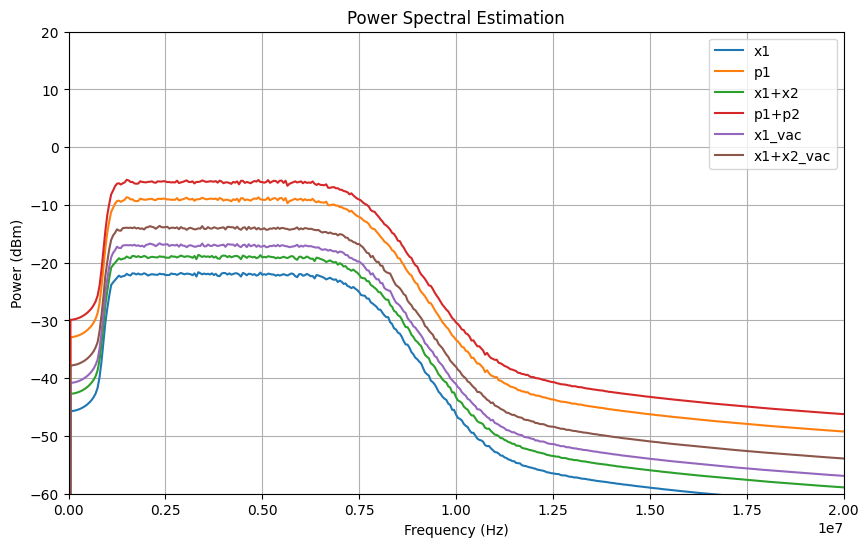

In [141]:
# Parameters
header_rows = 0
split_num = 1 # also is average number
window_seg_number = 500 # number of segments in each window 2000
sampling_rate = 100e6
zohms = 50

def spectrum_analysis(samples, sampling_rate, window_seg_number, split_num=1):
    split_size = len(samples) // split_num
    samples_split = np.array_split(samples[:split_size*split_num], split_num)
    # Welch's method for power spectral density estimation
    Pxx_avg_seg = []
    for i in range(split_num):
        f, Pxx_avg_seg1_ = welch(samples_split[i], fs=sampling_rate, window='boxcar', nperseg=len(samples_split[i])//window_seg_number, noverlap=None, scaling='spectrum')
        Pxx_avg_seg.append(Pxx_avg_seg1_)
    Pxx_avg = np.mean(Pxx_avg_seg, axis=0)
    Pxx_avg = 10 * np.log10(Pxx_avg / zohms) + 30
    return f, Pxx_avg

signal1 = initial0_samples_mode0[:, 0].cpu().numpy()
signal2 = initial0_samples_mode0[:, 1].cpu().numpy()
signal3 = initial0_samples_mode1[:, 0].cpu().numpy() + initial1_samples_mode1[:, 0].cpu().numpy()
signal4 = initial0_samples_mode1[:, 1].cpu().numpy() + initial1_samples_mode1[:, 1].cpu().numpy()
signal5 = initial0_samples_mode4[:, 0].cpu().numpy()
signal6 = initial0_samples_mode0[:, 1].cpu().numpy()
f1, Pxx_avg1 = spectrum_analysis(signal1, sampling_rate, window_seg_number, split_num=split_num)
f2, Pxx_avg2 = spectrum_analysis(signal2, sampling_rate, window_seg_number, split_num=split_num)
f3, Pxx_avg3 = spectrum_analysis(signal3, sampling_rate, window_seg_number, split_num=split_num)
f4, Pxx_avg4 = spectrum_analysis(signal4, sampling_rate, window_seg_number, split_num=split_num)
f5, Pxx_avg5 = spectrum_analysis(signal5, sampling_rate, window_seg_number, split_num=split_num)
f6, Pxx_avg6 = spectrum_analysis(signal6, sampling_rate, window_seg_number, split_num=split_num)

# Vacuum state
signal1_vac = initial0_samples_mode0_vac[:, 0].cpu().numpy()
signal2_vac = initial0_samples_mode0_vac[:, 1].cpu().numpy()
signal3_vac = initial0_samples_mode1_vac[:, 0].cpu().numpy() + initial1_samples_mode1_vac[:, 0].cpu().numpy()
signal4_vac = initial0_samples_mode1_vac[:, 1].cpu().numpy() + initial1_samples_mode1_vac[:, 1].cpu().numpy()
signal5_vac = initial0_samples_mode4_vac[:, 0].cpu().numpy()
f1_vac, Pxx_avg1_vac = spectrum_analysis(signal1_vac, sampling_rate, window_seg_number, split_num=split_num)
f2_vac, Pxx_avg2_vac = spectrum_analysis(signal2_vac, sampling_rate, window_seg_number, split_num=split_num)
f3_vac, Pxx_avg3_vac = spectrum_analysis(signal3_vac, sampling_rate, window_seg_number, split_num=split_num)
f4_vac, Pxx_avg4_vac = spectrum_analysis(signal4_vac, sampling_rate, window_seg_number, split_num=split_num)
f5_vac, Pxx_avg5_vac = spectrum_analysis(signal5_vac, sampling_rate, window_seg_number, split_num=split_num)

# Filter
filter_lower_bound = 1e6
filter_upper_bound = 8e6
filter_sampling_rate = 100e6
siganl1_filtered = butter_bandpass_filter(signal1, filter_lower_bound, filter_upper_bound, filter_sampling_rate, order=5)
siganl2_filtered = butter_bandpass_filter(signal2, filter_lower_bound, filter_upper_bound, filter_sampling_rate, order=5)
signal3_filtered = butter_bandpass_filter(signal3, filter_lower_bound, filter_upper_bound, filter_sampling_rate, order=5)
signal4_filtered = butter_bandpass_filter(signal4, filter_lower_bound, filter_upper_bound, filter_sampling_rate, order=5)
signal5_filtered = butter_bandpass_filter(signal1_vac, filter_lower_bound, filter_upper_bound, filter_sampling_rate, order=5)
signal6_filtered = butter_bandpass_filter(signal3_vac, filter_lower_bound, filter_upper_bound, filter_sampling_rate, order=5)
f1_filtered, Pxx_avg1_filtered = spectrum_analysis(siganl1_filtered, sampling_rate, window_seg_number, split_num=split_num)
f2_filtered, Pxx_avg2_filtered = spectrum_analysis(siganl2_filtered, sampling_rate, window_seg_number, split_num=split_num)
f3_filtered, Pxx_avg3_filtered = spectrum_analysis(signal3_filtered, sampling_rate, window_seg_number, split_num=split_num)
f4_filtered, Pxx_avg4_filtered = spectrum_analysis(signal4_filtered, sampling_rate, window_seg_number, split_num=split_num)
f5_filtered, Pxx_avg5_filtered = spectrum_analysis(signal5_filtered, sampling_rate, window_seg_number, split_num=split_num)
f6_filtered, Pxx_avg6_filtered = spectrum_analysis(signal6_filtered, sampling_rate, window_seg_number, split_num=split_num)

# Plot
print(f'Sampling rate: {sampling_rate/1000} kHz')
yrange = 80
yref = -20
plt.figure(figsize=(10, 6))
# plt.plot(f1, Pxx_avg1, label='x1')
# plt.plot(f2, Pxx_avg2, label='p1')
# plt.plot(f3, Pxx_avg3, label='x1+x2')
# plt.plot(f4, Pxx_avg4, label='p1+p2')
# plt.plot(f5, Pxx_avg5, label='signal5')
# plt.plot(f6, Pxx_avg6, label='signal6')

plt.plot(f1_filtered, Pxx_avg1_filtered, label='x1')
plt.plot(f2_filtered, Pxx_avg2_filtered, label='p1')
plt.plot(f3_filtered, Pxx_avg3_filtered, label='x1+x2')
plt.plot(f4_filtered, Pxx_avg4_filtered, label='p1+p2')
plt.plot(f5_filtered, Pxx_avg5_filtered, label='x1_vac')
plt.plot(f6_filtered, Pxx_avg6_filtered, label='x1+x2_vac')

# plt.plot(f1_vac, Pxx_avg1_vac, label='x1_vac')
# plt.plot(f2_vac, Pxx_avg2_vac, label='signal2_vac')
# plt.plot(f3_vac, Pxx_avg3_vac, label='x1+x2_vac')
# plt.plot(f4_vac, Pxx_avg4_vac, label='p1+p2_vac')
# plt.plot(f5_vac, Pxx_avg5_vac, label='signal5_vac')

plt.title('Power Spectral Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dBm)')
plt.xlim(0,20e6)
plt.ylim(yref-yrange/2, yref+yrange/2)
plt.legend()
plt.grid(True)
plt.show()


In [142]:
# Calculate nullifier: xA1+xB1+xA2-xB2 & pA1+pB1-pA2+pB2
def calculate_nullifierX(samples, s=0, e=N-2):
    nullifiers = []
    for i in tqdm(range(s, e)):
        nullifiers += [samples[:, 2*i+1, 0] + samples[:, 2*i, 0] + samples[:, 2*i+3, 0] - samples[:, 2*i+2, 0]]
    return nullifiers
def calculate_nullifierP(samples, s=0, e=N-2):
    nullifiers = []
    for i in tqdm(range(s, e)):
        nullifiers += [samples[:, 2*i+1, 1] + samples[:, 2*i, 1] - samples[:, 2*i+3, 1] + samples[:, 2*i+2, 1]]
    return nullifiers
print("Sample num per mode:", sample_num_per_mode, "\nDelay num: ", int(delay_num))

Sample num per mode: 10000 
Delay num:  10000


100%|██████████| 98/98 [00:00<00:00, 3499.90it/s]


0.16203601126159942 



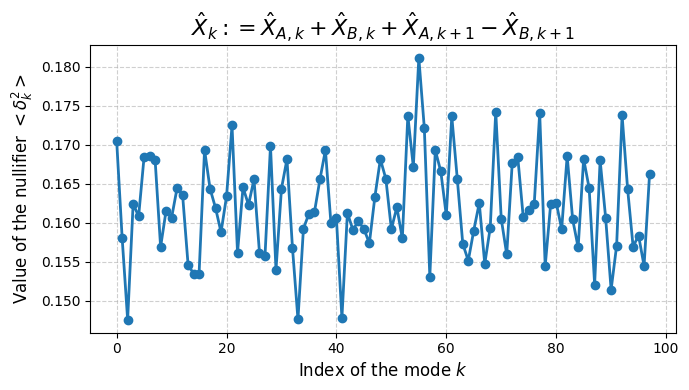

In [143]:
# Calculate all nullifier variances
result = [nullifier.clone().detach().var().item() for nullifier in calculate_nullifierX(mode4_samples, s=0, e=N-2)]

# (Optional) print average value
print(np.array(result).mean(),"\n")

# Plot result with polished aesthetics
plt.figure(figsize=(7, 4))
plt.plot(result, linewidth=2, marker='o')
plt.title('$\hat{X}_k := \hat{X}_{A,k} + \hat{X}_{B,k} + \hat{X}_{A,k+1} - \hat{X}_{B,k+1}$', fontsize=16)
plt.xlabel(f"Index of the mode $k$", fontsize=12)
plt.ylabel(f"Value of the nullifier $<\\delta^2_k>$", fontsize=12)
# plt.ylim(0, 2)  # Set y-axis limits from 0 to 2
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

100%|██████████| 98/98 [00:00<00:00, 3646.12it/s]


0.5151236698943742




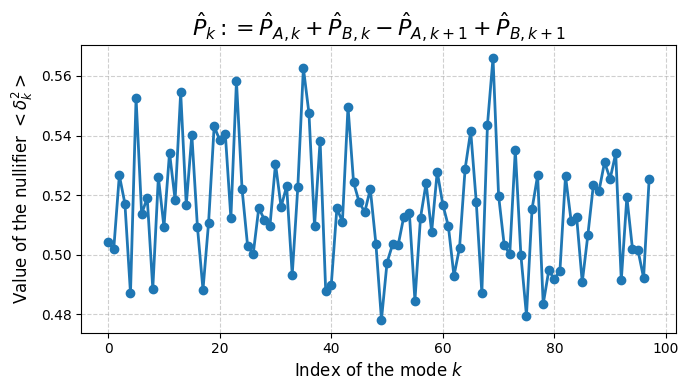

In [144]:
# Calculate all nullifier variances
result = [nullifier.clone().detach().var().item() for nullifier in calculate_nullifierP(mode4_samples_vac)]

# (Optional) print average value
print(np.array(result).mean())
print("\n")

# Plot result with polished aesthetics
plt.figure(figsize=(7, 4))
plt.plot(result, linewidth=2, marker='o')
plt.title('$\hat{P}_k := \hat{P}_{A,k} + \hat{P}_{B,k} - \hat{P}_{A,k+1} + \hat{P}_{B,k+1}$', fontsize=16)
plt.xlabel(f"Index of the mode $k$", fontsize=12)
plt.ylabel(f"Value of the nullifier $<\\delta^2_k>$", fontsize=12)
# plt.ylim(0, 2)  # Set y-axis limits from 0 to 2
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()